# Neural Network Approach for Insurance Premium Prediction

이 노트북에서는 XGBoost 등 트리 기반 모델의 한계(피처 간 복잡한 상호작용 포착 어려움)를 극복하기 위해,
**Deep Learning (Multi-Layer Perceptron)** 모델을 사용하여 자동으로 피처를 추출하고 학습하는 실험을 수행합니다.

### Strategy
1. **Input Data**: 로그 변환된 데이터(`train_log_processed_final.csv`)를 사용.
   - Neural Network는 입력 분포가 정규분포에 가까울수록 학습이 잘 됩니다.
2. **Scaling**: `StandardScaler` 필수 적용.
   - 트리는 스케일에 무관하지만, NN은 모든 입력 변수의 스케일이 맞춰져 있어야 합니다.
3. **Model**: 3~4개의 은닉층(Hidden Layers)을 가진 MLP 모델.
   - 이를 통해 변수 간의 고차원 상호작용(Interaction)을 모델이 스스로 학습하게 유도합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [2]:
import os
import matplotlib.pyplot as plt

def save_plot(fig, filename, save_dir='/home/pluto2477/Documents/ML_final_report/image'):
    # 디렉토리 생성
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"Directory created: {save_dir}")
    
    # 전체 경로 생성
    full_path = os.path.join(save_dir, filename)
    
    # 이미지 저장
    try:
        fig.savefig(full_path, dpi=300, bbox_inches='tight')
        print(f"Image successfully saved to: {full_path}")
    except Exception as e:
        print(f"Error saving image: {e}")

In [3]:
# 1. 데이터 로드 (이미 로그 변환된 데이터 사용 권장)
train_path = '../data/train_log_processed_final.csv'
test_path = '../data/test_log_processed_final.csv'

# 데이터가 없으면 기존 경로 시도
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
except FileNotFoundError:
    # 절대 경로 fallback
    train_df = pd.read_csv('/home/pluto2477/Documents/ML_final_report/data/train_log_processed_final.csv')
    test_df = pd.read_csv('/home/pluto2477/Documents/ML_final_report/data/test_log_processed_final.csv')

print("Data Loaded. Shape:", train_df.shape)
train_df.head()

Data Loaded. Shape: (1200000, 31)


,Age,Annual Income,Number of Dependents,Education Level,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,...,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Smoking Status_Yes,Property Type_Condo,Property Type_House
0,19.0,9.215328,1.0,1,22.598761,1.098612,17.0,372.00000,5.0,0,...,True,False,False,False,True,False,True,False,False,True
1,39.0,10.363409,3.0,2,15.569731,0.693147,12.0,694.00000,2.0,1,...,False,False,True,False,False,True,False,True,False,True
2,23.0,10.150465,3.0,0,47.177549,0.693147,14.0,592.92435,3.0,2,...,True,False,False,True,False,False,True,True,False,True
3,21.0,11.862568,2.0,1,10.938144,0.693147,0.0,367.00000,1.0,0,...,False,False,True,False,False,False,False,True,False,False
4,21.0,10.587897,1.0,1,20.376094,0.000000,8.0,598.00000,4.0,0,...,True,False,False,False,False,False,True,True,False,True


In [4]:
# 2. 데이터 분리 및 스케일링 (NN의 핵심!)

X = train_df.drop('Premium Amount', axis=1)
y = train_df['Premium Amount']  # 이미 log1p 변환되어 있음

# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling (평균 0, 분산 1로 변환)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Feature Scaling Completed.")

Feature Scaling Completed.


In [5]:
# 3. Neural Network 모델 구성 및 학습
# MLPRegressor (Scikit-learn의 간단한 딥러닝 모델)

print("Training Neural Network...")

model_nn = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),  # 3개의 은닉층 (점점 줄어드는 구조)
    activation='relu',                 # 가장 무난한 활성화 함수
    solver='adam',                     # Optimizer
    alpha=0.0001,                      # L2 규제 (과적합 방지)
    batch_size=256,                    # 미니배치 크기
    learning_rate='adaptive',          # 학습률 자동 조절
    learning_rate_init=0.001,          # 초기 학습률
    max_iter=500,                      # 최대 에폭
    early_stopping=True,               # 성능 안 오르면 조기 종료
    validation_fraction=0.1,           # 내부 검증 데이터 비율
    n_iter_no_change=20,               # 20번 참음
    random_state=42,
    verbose=True                       # 학습 과정 출력
)

model_nn.fit(X_train_scaled, y_train)
print("Training Completed.")

Training Neural Network...
Iteration 1, loss = 0.74575528
Validation score: -0.012684
Iteration 2, loss = 0.59798081
Validation score: 0.011558
Iteration 3, loss = 0.59489539
Validation score: 0.006867
Iteration 4, loss = 0.59232733
Validation score: 0.013320
Iteration 5, loss = 0.58963847
Validation score: 0.016705
Iteration 6, loss = 0.58678400
Validation score: 0.029894
Iteration 7, loss = 0.58419391
Validation score: 0.015177
Iteration 8, loss = 0.58247376
Validation score: 0.032030
Iteration 9, loss = 0.58092704
Validation score: 0.030503
Iteration 10, loss = 0.57967094
Validation score: 0.036611
Iteration 11, loss = 0.57855939
Validation score: 0.038918
Iteration 12, loss = 0.57781405
Validation score: 0.038069
Iteration 13, loss = 0.57677679
Validation score: 0.040042
Iteration 14, loss = 0.57609944
Validation score: 0.042246
Iteration 15, loss = 0.57515589
Validation score: 0.040745
Iteration 16, loss = 0.57464754
Validation score: 0.042105
Iteration 17, loss = 0.57398452
Valid

In [6]:
# 4. 평가 (XGBoost와 비교)

# 예측 (Log Scale)
y_pred_log_nn = model_nn.predict(X_val_scaled)

# 원래 스케일로 복원
y_pred_real_nn = np.expm1(y_pred_log_nn)
y_val_real = np.expm1(y_val)

# 지표 계산
mae_nn = mean_absolute_error(y_val_real, y_pred_real_nn)
r2_nn = r2_score(y_val_real, y_pred_real_nn)

print(f"\n[Neural Network Results]")
print(f"MAE: {mae_nn:.4f}")
print(f"R2 : {r2_nn:.4f}")


[Neural Network Results]
MAE: 633.5185
R2 : -0.1629


Image successfully saved to: /home/pluto2477/Documents/ML_final_report/image/nn_modeling.png


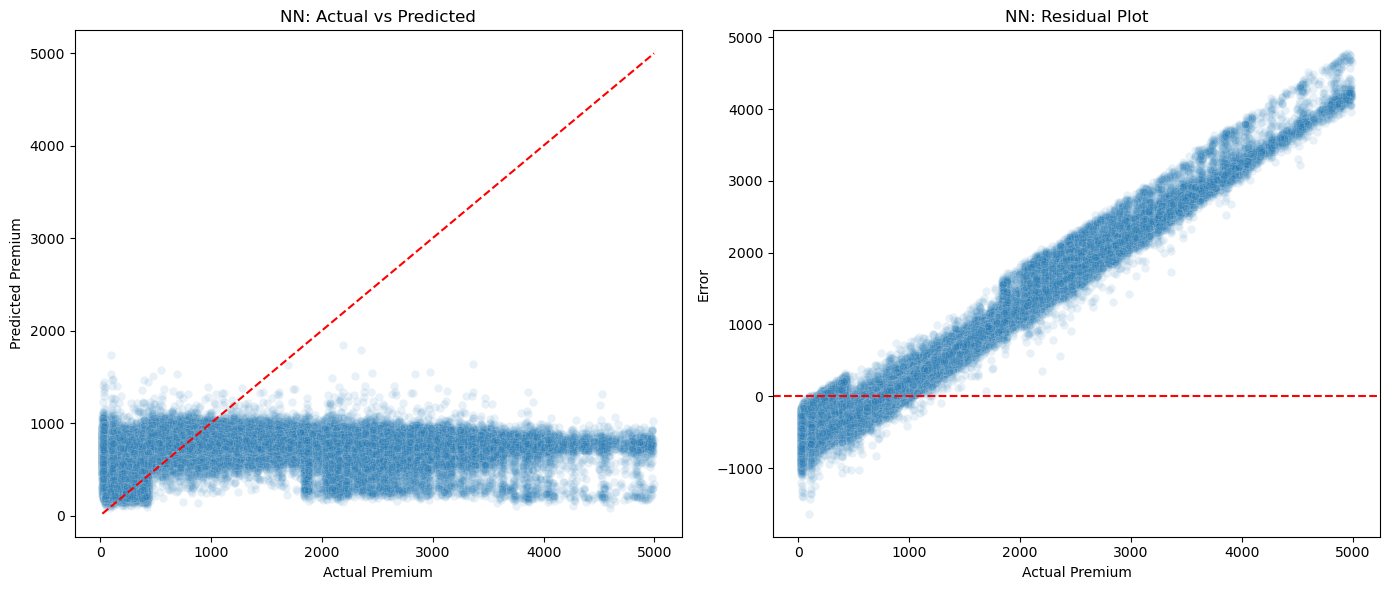

In [7]:
# 5. 결과 시각화 (잔차 패턴 확인)
plt.figure(figsize=(14, 6))

# A. Actual vs Predicted
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_val_real, y=y_pred_real_nn, alpha=0.1)
plt.plot([y_val_real.min(), y_val_real.max()], [y_val_real.min(), y_val_real.max()], 'r--', label='Perfect')
plt.title('NN: Actual vs Predicted')
plt.xlabel('Actual Premium')
plt.ylabel('Predicted Premium')

# B. Residual Plot
residuals = y_val_real - y_pred_real_nn
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_val_real, y=residuals, alpha=0.1)
plt.axhline(0, color='r', linestyle='--')
plt.title('NN: Residual Plot')
plt.xlabel('Actual Premium')
plt.ylabel('Error')

plt.tight_layout()
save_plot(plt.gcf(), 'nn_modeling.png') 
plt.show()